- Implement U-Net segmentation, using to solve Inverse Scattering Problem.

# Download data

In [ ]:
!cp -r "/content/drive/MyDrive/Colab Notebooks/cau_liem/data/training_data.h5" /content/training_data.h5
!cp -r "/content/drive/MyDrive/Colab Notebooks/cau_liem/data/validation_data.h5" /content/validation_data.h5
!cp -r "/content/drive/MyDrive/Colab Notebooks/cau_liem/data/testing_data.h5" /content/testing_data.h5

# Prepare paths of input images and target segmenatation 

In [ ]:
import os
import numpy as np
import h5py
import cv2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

IMAGE_SIZE = 160

TARGET_IMAGE_SIZE = 160
TARGET_IMAGE_SIZE_BEFORE_CROP = int(TARGET_IMAGE_SIZE * 1.05)

img_size = (IMAGE_SIZE, IMAGE_SIZE)
num_classes = 1
BATCH_SIZE = 32

In [ ]:
hf = h5py.File('training_data.h5', 'r')
train_input_img = hf['inputImage'][:]
train_target_img = hf['targetImage'][:]
hf.close()

hf = h5py.File('validation_data.h5', 'r')
val_input_img = hf['inputImage'][:]
val_target_img = hf['targetImage'][:]
hf.close()

In [ ]:
print("train input ", train_input_img.shape)
print("train target ", train_target_img.shape)
print("val input ", val_input_img.shape)
print("val target ", val_target_img.shape)

train input  (50000, 160, 160, 3)
train target  (50000, 160, 160, 1)
val input  (5000, 160, 160, 3)
val target  (5000, 160, 160, 1)


# Load test image

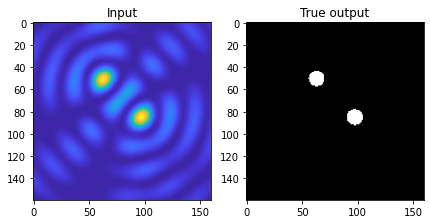

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2


idx = 305

inputImage = cv2.cvtColor(train_input_img[idx], cv2.COLOR_BGR2RGB)
targetImage = train_target_img[idx].squeeze()

f, axarr = plt.subplots(1,2, figsize=(7,7))

axarr[0].imshow(inputImage)
axarr[0].title.set_text('Input')

axarr[1].imshow(targetImage, cmap="gray")
axarr[1].title.set_text('True output')


# Prepare Sequence class to load and vectorize batches of data

In [ ]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE

def rescale(input_image, output_mask):
    
    # input_image = tf.image.resize(input_image, [TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE], "nearest")
    input_image = tf.cast(input_image, tf.float32)
    input_image = (input_image / 255.0)

    # output_mask = tf.image.resize(output_mask, [TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE], "nearest")

    return input_image, output_mask

def random_crop(input_image, output_mask):
  
    input_image = tf.image.resize(input_image, [TARGET_IMAGE_SIZE_BEFORE_CROP, TARGET_IMAGE_SIZE_BEFORE_CROP], "nearest")
    output_mask = tf.image.resize(output_mask, [TARGET_IMAGE_SIZE_BEFORE_CROP, TARGET_IMAGE_SIZE_BEFORE_CROP], "nearest")

    output_mask = tf.concat([output_mask, output_mask, output_mask], axis=-1)
    stacked_image = tf.stack([input_image, output_mask], axis=0)

    cropped_image = tf.image.random_crop(stacked_image, size=[2, TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE, 3])

    input_image = cropped_image[0, :, :, :]
    output_mask = tf.reshape(cropped_image[1, :, :, 0], (TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE, 1))

    return input_image, output_mask

def my_augmentation(input_image, output_mask):

    seed = (np.random.randint(100), np.random.randint(200))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.rot90(input_image)
        output_mask = tf.image.rot90(output_mask)

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.stateless_random_flip_left_right(input_image, seed)
        output_mask = tf.image.stateless_random_flip_left_right(output_mask, seed)

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.stateless_random_flip_up_down(input_image, seed)
        output_mask = tf.image.stateless_random_flip_up_down(output_mask, seed)

    return input_image, output_mask

# Function use to fetch input data
def Wave_Dataset(input_images, target_images, batch_size, is_training=False):

    # convert the input to a dataset
    dataset = tf.data.Dataset.from_tensor_slices((input_images, target_images))

    # Perform random crop 
    if is_training == True:
        dataset = dataset.map(lambda x, y: random_crop(x, y), num_parallel_calls=AUTOTUNE)

    # shuffle, repeat and batch the examples
    if is_training == True:
        dataset = dataset.shuffle(input_images.shape[0], reshuffle_each_iteration=True)
        dataset = dataset.repeat()
    
    dataset = dataset.batch(batch_size)

    # Resize and rescale all datasets
    dataset = dataset.map(lambda x, y: rescale(x, y), num_parallel_calls=AUTOTUNE)

    if is_training == True:
        # Perform data augmentation
        dataset = dataset.map(lambda x, y: my_augmentation(x, y), num_parallel_calls=AUTOTUNE)
    
    return dataset.prefetch(buffer_size=AUTOTUNE)

# Prepare U-Net Xception-style model

In [ ]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Prepare data

In [ ]:
train_gen = Wave_Dataset(train_input_img, train_target_img, batch_size=BATCH_SIZE, is_training=True)
val_gen = Wave_Dataset(val_input_img, val_target_img, batch_size=BATCH_SIZE, is_training=False)

# Train the model

In [ ]:
img_size = (TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE)


# Build model
model = get_model(img_size, num_classes)
model.summary()

model.compile(optimizer='adam',
            steps_per_execution = 50,
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=4, min_lr=0.000001, verbose=1),
    ModelCheckpoint('cauliem_30_07_mask.h5', verbose=1, save_best_only=True, save_weights_only=False)
]

epochs = 100

STEPS_PER_EPOCH = len(train_input_img) // BATCH_SIZE
VAL_STEPS = len(val_input_img) // BATCH_SIZE

H = model.fit(train_gen, steps_per_epoch = STEPS_PER_EPOCH,\
        validation_data=val_gen, validation_steps = VAL_STEPS, \
        epochs=epochs, \
        callbacks=callbacks)

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/cau_liem/result/cauliem_30_07_mask.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Test entire testing dataset

In [ ]:
hf = h5py.File('images_test.h5', 'r')
# print(hf.keys())

trueImages = hf['trueImages'][:]
blurImages = hf['blurImages'][:]

hf.close()

if TARGET_IMAGE_SIZE != IMAGE_SIZE:
    blurImages = [cv2.resize(image, (TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE)) for image in blurImages]
    blurImages = np.array(blurImages)

blurImages = blurImages.astype(np.float32) / 255.0

print("true images ", trueImages.shape)
print("blue images ", blurImages.shape)

true images  (100, 160, 160, 3)
blue images  (100, 160, 160, 3)


In [ ]:
# maskGen = Testing_Dataset(blurImages, batch_size=BATCH_SIZE)
from tensorflow.keras.models import load_model

model = load_model("/content/cauliem_30_07_mask.h5")

predictImages = model.predict(blurImages)
print(predictImages.shape)
print(predictImages.dtype)

(100, 160, 160, 1)
float32


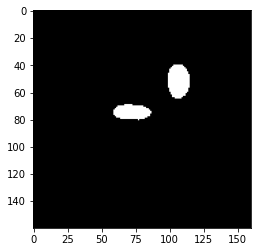

In [ ]:
# Display Y image
plot_image = predictImages[19]

threshold = 0.9

plot_image[plot_image > threshold] = 255
plot_image[plot_image <= threshold] = 0

plot_image = np.reshape(plot_image, (TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE))
plot_image = plot_image.astype("uint8")
plt.imshow(plot_image, cmap="gray")

In [ ]:
!mkdir "/content/cauliem_30_07_mask"

threshold = 0.5

OUTPUT_PATH = "/content/cauliem_30_07_mask"

for (i, image) in enumerate(predictImages):

    fileName = "predict_" + str(i + 1) + ".jpg"
    path = os.path.join(OUTPUT_PATH, fileName)

    image[image > threshold] = 255
    image[image <= threshold] = 0

    image = np.reshape(image, (TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE))
    image = image.astype("uint8")

    cv2.imwrite(path, image)

In [ ]:
!cp -r "/content/cauliem_30_07_mask" "/content/drive/MyDrive/Colab Notebooks/cau_liem/Output"

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("cauliem_30_07_mask.h5")

model.save("/content/drive/MyDrive/Colab Notebooks/cau_liem/result/cauliem_30_07_mask.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Evaluation

In [ ]:
hf = h5py.File('testing_data.h5', 'r')
test_input_img = hf['inputImage'][:]
test_target_img = hf['targetImage'][:]
hf.close()

print("test input ", test_input_img.shape)
print("test target ", test_target_img.shape)

test input  (5000, 160, 160, 3)
test target  (5000, 160, 160, 1)


In [ ]:
# Resize image if necessary

if test_input_img.shape[1] != TARGET_IMAGE_SIZE:
    
    test_input_img = [cv2.resize(image, (TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE)) for image in test_input_img]
    test_input_img = np.array(test_input_img)

    test_target_img = [cv2.resize(image, (TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE)) for image in test_target_img]
    test_target_img = np.array(test_target_img)

# Normalize image
test_input_img = test_input_img.astype(np.float32) / 255.0


print("test input ", test_input_img.shape)
print("test target ", test_target_img.shape)
print("----------------------------------")
print("test input ", test_input_img.dtype)
print("test target ", test_target_img.dtype)

test input  (5000, 160, 160, 3)
test target  (5000, 160, 160, 1)
----------------------------------
test input  float32
test target  uint8


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/content/cauliem_30_07_mask.h5")

model.evaluate(test_input_img, test_target_img, batch_size=32)

157/157 [==============================] - 6s 35ms/step - loss: 0.0138 - accuracy: 0.9942


[0.013814271427690983, 0.9941723942756653]

# Plot the training loss and accuracy

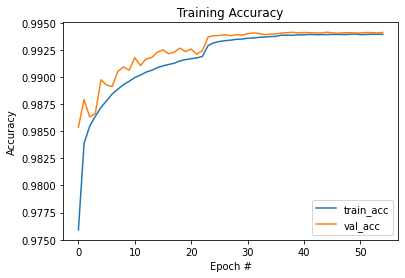

In [ ]:
plt.figure()
plt.plot(np.arange(0, 55), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 55), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()

plt.savefig('accuracy.png')

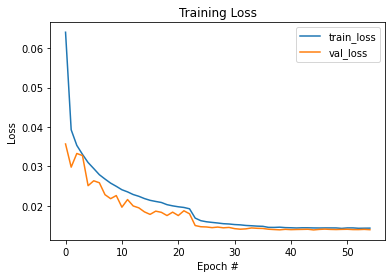

In [ ]:
plt.figure()

plt.plot(np.arange(0, 55), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 55), H.history["val_loss"], label="val_loss")

plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

plt.savefig('loss.png')

# Intersection over Union (IoU)

In [ ]:
from keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

In [ ]:
hf = h5py.File('testing_data.h5', 'r')
test_input_img = hf['inputImage'][:]
test_target_img = hf['targetImage'][:]
hf.close()

print("test input ", test_input_img.shape)
print("test input ", test_input_img.dtype)
print("----------------------------------")
print("test target ", test_target_img.shape)
print("test target ", test_target_img.dtype)

test input  (5000, 160, 160, 3)
test input  uint8
----------------------------------
test target  (5000, 160, 160, 1)
test target  uint8


In [ ]:
test_input_img = test_input_img.astype(np.float32) / 255.0
test_target_img = test_target_img.astype(np.float32)

print("test input ", test_input_img.shape)
print("test input ", test_input_img.dtype)
print("----------------------------------")
print("test target ", test_target_img.shape)
print("test target ", test_target_img.dtype)

test input  (5000, 160, 160, 3)
test input  float32
----------------------------------
test target  (5000, 160, 160, 1)
test target  float32


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/Colab Notebooks/cau_liem/result/cauliem_30_07_mask.h5")

test_predict_img = model.predict(test_input_img, verbose=1)

print(test_predict_img.shape)
print(test_predict_img.dtype)

157/157 [==============================] - 21s 28ms/step
(5000, 160, 160, 1)
float32


In [ ]:
IoU_accuracy = iou_coef(test_target_img, test_predict_img)

print("IoU accuracy: {}".format(IoU_accuracy))

IoU accuracy: 0.8666048645973206
